In [1]:
# 1. 데이터 준비 및 확인

import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re


from konlpy.tag import Okt
from konlpy.tag import Mecab
# pip install konlyp 를 통해 설치

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


train_data = pd.read_table('~/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
# 2. 데이터로더 구성

# imdb.data.loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와
#  word_to_index 딕셔너리까지 친절하게 제공한다. 
#  하지만 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져있어, 
#  imdb_loader() 와 동일하게 동작하는 data_loader 를 만들어야 한다. 
#  data_loader 안에서는 다음을 수행해야 한다.

#    1. 데이터의 중복제거
#    2. 결측치 제거
#    3. 한국어 토크나이저로 토큰화
#    4. 불용어(Stopwords) 제거
#    5. 사전 `word_to_index` 구성
#    6. 텍스트 스트링을 사전 인텍스 스티링으로 변환
#    7. X_train, y_train, X_test, y_tesr, word_to_index 리턴



# 데이터 중복 확인

# id는 150000개 인데, document 는 146182개면, document 에서 약 4000개의 자료가 중복
print(train_data.nunique())

print(test_data.nunique())

id          150000
document    146182
label            2
dtype: int64
id          50000
document    49157
label           2
dtype: int64


In [3]:
# 토크나이저 생성

tokenizer = Mecab()

# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 위에서 확인한 document 컬럼 값의 중복을 제거하고 저장
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 훈련 데이터 셋, 테스트 데이터 셋 확인
print("훈련 샘플 개수 :{}, 테스트 개수 : {}".format(len(X_train),len(X_test)))

훈련 샘플 개수 :146182, 테스트 개수 : 49157


In [4]:
# 

index_to_word = {index : word for word, index in word_to_index.items()}

In [5]:

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index) : 
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
print(get_encoded_sentence('i eat lunch', word_to_index))

# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode 해주는 함수
def get_encoded_sentences(sentences, word_to_index) : 
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode 된 문장을 원래대로 decode 하는 함수
# [1 : ] 를 통해 <BOS> 를 제외
def get_decoded_sentence(encoded_sentence, index_to_word) :
    return ''.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1 : ])

# 여러개의 숫자 벡터로 encode 된 문장을 한꺼번에 원래대로 decoded 하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word) :
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

[1, 5232, 2, 2]


In [6]:
# 모델구성을 위한 데이터 분석 및 가공

# 데이터셋 내 문장 길이 분포
# 적절한 최대 문장 길이 지정
# keras.preprocessing.sequence.pad_squences 을 활용한 패딩 추가

# encode 된 텍스트의 decode 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더빙..진짜짜증나네요목소리
라벨:  0


In [7]:
# 데이터 셋 내 문장길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이 평균, 최대, 표준편차 확인
print("문장길이 평균 : ", np.mean(num_tokens))
print("문장길이 최대 : ", np.max(num_tokens))
print("문장길이 표준편차 : ", np.std(num_tokens))

# 적절한 최대 문장 길이 지정
# 최대길이
max_tokens = np.mean(num_tokens) + 4 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen :  ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.' .format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :   67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다.


In [8]:
# validation set 구성

x_train = keras.preprocessing.sequence.pad_sequences(X_train, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

print(x_train.shape)

x_train = keras.preprocessing.sequence.pad_sequences(x_train, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test, value = word_to_index["<PAD>"], padding = 'pre', maxlen = maxlen)

print(x_train.shape)

(146182, 67)
(146182, 67)


In [9]:
# RNN 모델 구성

vocab_size = 10000

word_vector_dim = 16

model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
# CNN 을 통한 텍스트 데이터 분석

# 검증용 데이터 셋 분리
x_val = x_train[:10000]
y_val = y_train[:10000]


# 검증용 데이터 셋을 제외한 나머지
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


In [12]:
# 모델 훈련

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# 훈련 횟수
epochs = 20

history = model.fit(partial_x_train, partial_y_train, epochs = epochs, batch_size = 512, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/20
266/266 [==============================] - 2s 9ms/step - loss: 0.4871 - accuracy: 0.7742 - val_loss: 0.3543 - val_accuracy: 0.8477
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3368 - accuracy: 0.8581 - val_loss: 0.3416 - val_accuracy: 0.8511
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3163 - accuracy: 0.8676 - val_loss: 0.3407 - val_accuracy: 0.8542
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3060 - accuracy: 0.8720 - val_loss: 0.3437 - val_accuracy: 0.8523
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2972 - accuracy: 0.8753 - val_loss: 0.3441 - val_accuracy: 0.8504
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2892 - accuracy: 0.8792 - val_loss: 0.3449 - val_accuracy: 0.8519
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2819 - accuracy: 0.8832 - val_loss: 0.3467 - val_accuracy: 0.8538
Epoch 

In [13]:
# 테스트 셋 평가

result = model.evaluate(x_test, y_test, verbose = 2)

print(result)

1537/1537 - 3s - loss: 0.4514 - accuracy: 0.8439
[0.4514215886592865, 0.8439286351203918]


In [14]:
# 모델 학습 중 트레인 데이터 셋 / 검증용 데이터 셋의 loss, accuracy 등을 
# 매 echo 마다 history 에 저장

history_dict = history.history

# 매 echo 에 따른 그래프를 그릴 수 있는 항목들
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


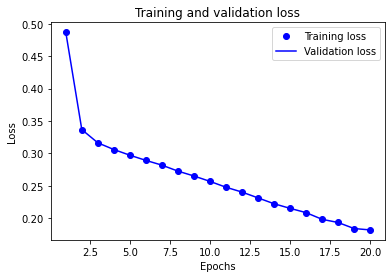

In [15]:
# Loss, Accuracy 시각화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')

plt.plot(epochs, loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

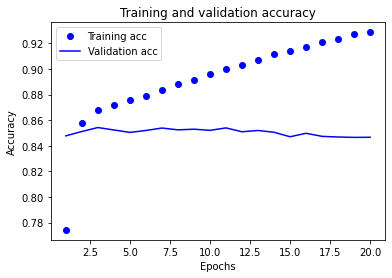

In [16]:
# 시각화한 그림을 초기화

plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# 1-D CNN 모델을 통한 학습

vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 30   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 30)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3376      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
# GlobalMaxPooling 1D() 만을 사용

vocab_size = 10000
word_vector_dim = 300   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________
